<a href="https://colab.research.google.com/gist/dilithjay/5a15b87e3594b6c8eb995d12034a390f/custom-image-classification-with-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [22]:
import glob
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image, ImageReadMode

# Datasets and Dataloaders

In [23]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [24]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.basename(os.path.dirname(path)))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label), self.image_paths[idx]

In [25]:
dataset = CustomDataset('images1/', transform)

In [26]:
splits = [0.8, 0.1, 0.1]
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [27]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=8, shuffle=True),
    "test": DataLoader(test_set, batch_size=8, shuffle=False),
    "val": DataLoader(val_set, batch_size=8, shuffle=False)
}

# Model Definition

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [29]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(2048, 4)
model.to(device)
pass

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training

In [31]:
EPOCHS = 20
NUM_CLASSES = len(dataset.class_lbl)

In [32]:
dataset.class_lbl

{'masked': 0, 'masked_sunglasses': 1, 'neutral': 2, 'sunglasses': 3}

In [33]:
metrics = {
    'train': {'loss': [], 'accuracy': []},
    'val': {'loss': [], 'accuracy': []},
}

In [34]:
val_acc = 0
for epoch in range(EPOCHS):
  ep_metrics = {
    'train': {'loss': 0, 'accuracy': 0, 'count': 0},
    'val': {'loss': 0, 'accuracy': 0, 'count': 0},
  }

  print(f'Epoch {epoch}')

  for phase in ['train', 'val']:
    print(f'-------- {phase} --------')
    for images, labels, _ in tqdm(dataloaders[phase]):
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels,
                                                num_classes=NUM_CLASSES)
        loss = criterion(output, ohe_label.float().to(device))

        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

      ep_metrics[phase]['loss'] += loss.item()
      ep_metrics[phase]['accuracy'] += accuracy.item()
      ep_metrics[phase]['count'] += 1
  
    ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
    ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

    metrics[phase]['loss'].append(ep_loss)
    metrics[phase]['accuracy'].append(ep_accuracy)
    if(phase == 'val' and ep_accuracy>val_acc):
      torch.save(model, "saved_models/best_model.pth")
      print(val_acc)
      val_acc = ep_accuracy
  torch.save(model, "saved_models/model_" + str(epoch) + ".pth")

Epoch 0
-------- train --------


  0%|          | 0/268 [00:00<?, ?it/s]c:\Users\yagya\AppData\Local\Continuum\anaconda3\envs\controlexpert\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  9%|▉         | 24/268 [00:05<00:51,  4.70it/s]


KeyboardInterrupt: 

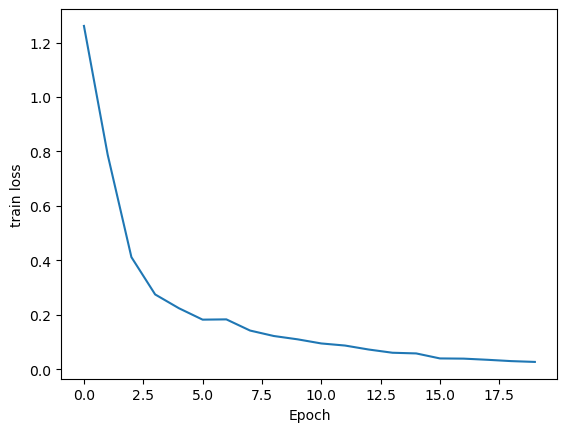

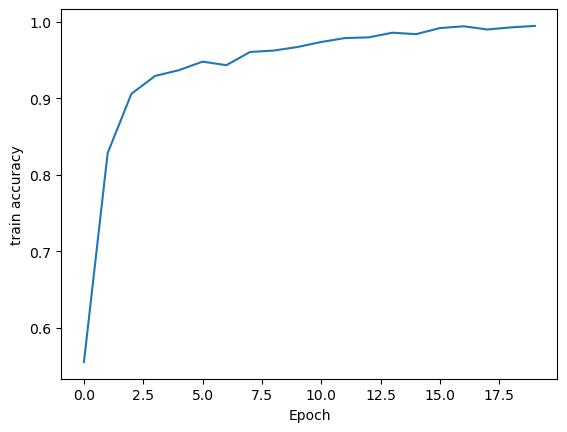

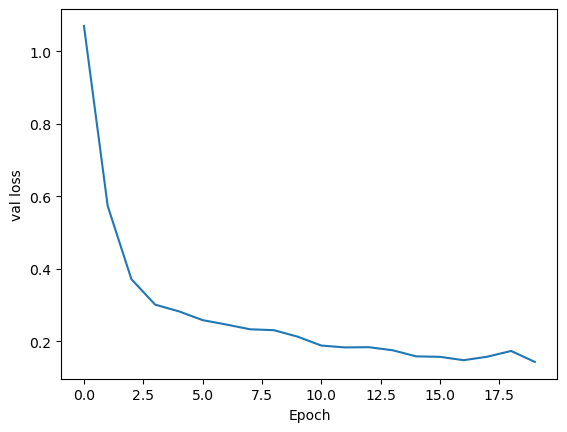

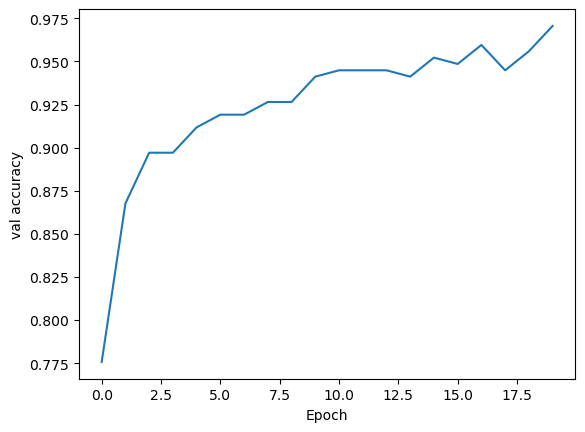

In [ ]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

# Testing

In [35]:
model = torch.load("saved_models/best_model.pth")
preds = []
actual = []

tot_loss = tot_acc = count = 0

misclassified = []

for images, labels, img_paths in tqdm(dataloaders['test']):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        mis_paths = [[img_paths[i], x.item(), y.item()] for i, (x,y) in enumerate(zip(labels, out_labels)) if x != y]
        if(len(mis_paths) > 0):
            misclassified.append(mis_paths[0])
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

100%|██████████| 34/34 [00:02<00:00, 11.43it/s]

Test Loss: 0.06314985454082489, Test Accuracy: 0.9852941036224365


['masked', 'masked_sunglasses', 'neutral', 'sunglasses']


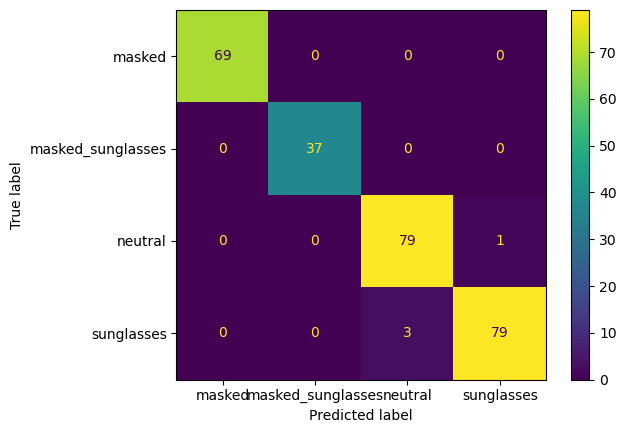

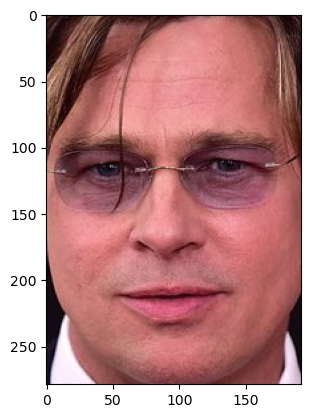

Original class: sunglasses  Predicted class: neutral


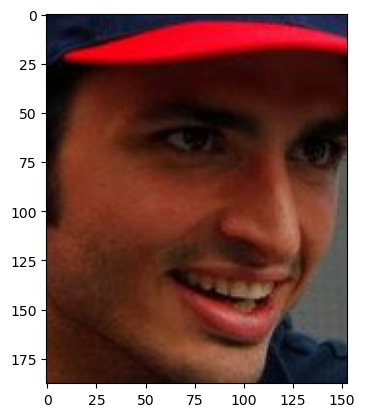

Original class: sunglasses  Predicted class: neutral


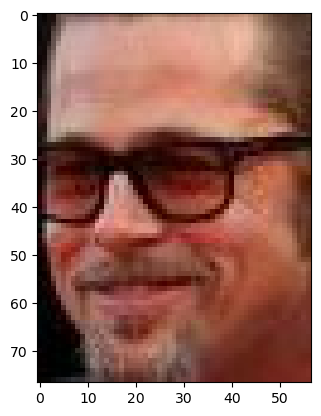

Original class: neutral  Predicted class: sunglasses


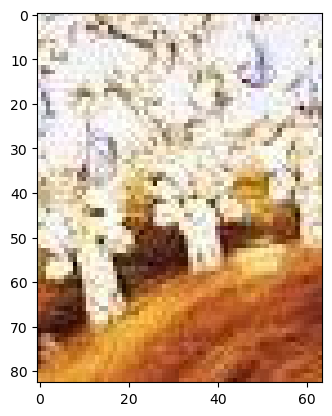

Original class: sunglasses  Predicted class: neutral


In [36]:
import shutil

class_labels = sorted(dataset.class_lbl.keys())
print(class_labels)

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

for i in misclassified:
    shutil.copy(i[0], "misclassified/")
    img = plt.imread(i[0])
    imgplot = plt.imshow(img)
    plt.show()
    print("Original class:", class_labels[i[1]], " Predicted class:", class_labels[i[2]])
    

In [37]:
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]

In [38]:
stats

,Precision,Recall
masked,1.000000,1.000000
masked_sunglasses,1.000000,1.000000
neutral,0.963415,0.987500
sunglasses,0.987500,0.963415


# Image Inference

In [39]:
from facenet_pytorch import MTCNN
import mmcv, cv2
from PIL import Image, ImageDraw, ImageFont
from IPython import display

mtcnn = MTCNN(keep_all=True, device=device, image_size=128)
classes = ["masked", "masked_sunglasses", "neutral", "sunglasses"]

model_infer = torch.load("saved_models/best_model.pth")

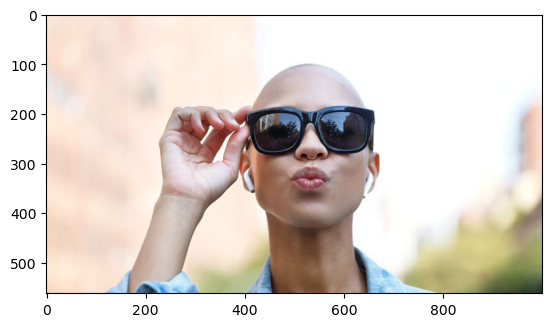

Image class:  sunglasses  Confidence:  70.3 %


In [40]:
img_infer = Image.open("../Face_detection/examples/2.jpg")
img = mtcnn(img_infer, save_path="../Face_detection/detected/masked/2.jpg")

img_dis = plt.imread("../Face_detection/examples/2.jpg")
imgplot = plt.imshow(img_dis)
plt.show()

# img_infer = img_infer[None, :, : , :]
# assert img_infer.shape == ()
result = model_infer(img.to(device))
s_result = torch.nn.functional.softmax(result, dim=1)
out_label = torch.argmax(s_result, dim=1)

out_c = s_result.cpu().detach().numpy()
out = out_label.cpu().detach().numpy()
for key, val in dataset.class_lbl.items():
    if(val == out[0]): 
        print("Image class: ", key, " Confidence: ", round(np.max(out_c*100),2) , "%")

# Video inference

Tracking frame: 146

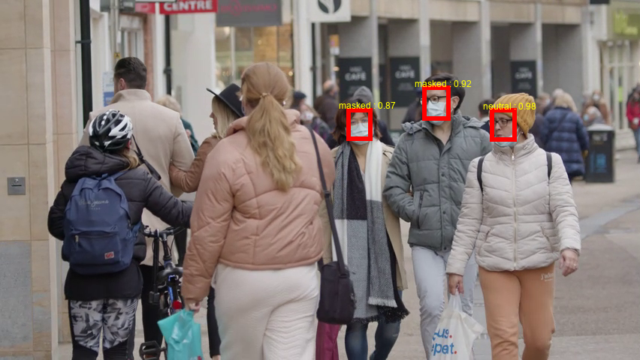

In [41]:
video = mmcv.VideoReader("../Face_detection/videos/masked.mp4")
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
frames_tracked = []
model = torch.load("saved_models/best_model.pth")
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
        
    # Detect faces
    boxes, _ = mtcnn.detect(frame)

    # Save cropped images
    img = mtcnn(frame, save_path="../Face_detection/detected/masked/" + str(i) + ".jpg")
        
    if(img is not None):
        result = model(img.to(device))
        s_result = torch.nn.functional.softmax(result, dim=1)
        out_label = torch.argmax(result, dim=1)
        out_c = s_result.cpu().detach().numpy()
        out = out_label.cpu().detach().numpy()
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    if(boxes is not None):
        for out1, out_c1, box in zip(out, out_c, boxes):
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
            draw.text((box[0]-10, box[1]-10), classes[out1] + " : " + str(round(np.max(out_c1), 2)), font=ImageFont.truetype('arial', 12), fill=(255,255,0,255))
    else:
        continue
        
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
    
d = display.display(frames_tracked[72], display_id=True)
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('../Face_detection/tracked_videos/masked_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()